# Exploration and Exploitation

In [1]:
using PGFPlots
using Interact
using Reactive
using Distributions
include("helpers.jl")
include("bandits.jl");

## Multi-Armed Bandit Problems

In [2]:
srand(0)
arms = 3
b = Bandit(arms)
banditTrial(b)

Interact.Button{Void}(Signal{Void}(nothing, nactions=2),"Arm 1",nothing)

Interact.Latex("","0 wins out of 0 tries (NaN percent)")

Interact.Button{Void}(Signal{Void}(nothing, nactions=2),"Arm 2",nothing)

Interact.Latex("","0 wins out of 0 tries (NaN percent)")

Interact.Button{Void}(Signal{Void}(nothing, nactions=2),"Arm 3",nothing)

Interact.Latex("","0 wins out of 0 tries (NaN percent)")

Interact.Options{:ToggleButtons,ASCIIString}(Signal{ASCIIString}(Hide, nactions=0),"True parameters","Hide","Hide",Interact.OptionDict(Any["Hide","Show"],Dict{Any,Any}("Hide"=>"Hide","Show"=>"Show")),Any[],Any[])

LoadError: LoadError: MethodError: `start` has no method matching start(::Interact.Options{:ToggleButtons,ASCIIString})
while loading In[2], in expression starting on line 4

## Bayesian Model Estimation

Button{Nothing}([Input{Nothing}] nothing,"Arm 1",nothing)

Latex("","0 wins out of 0 tries (NaN percent)")

Button{Nothing}([Input{Nothing}] nothing,"Arm 2",nothing)

Latex("","0 wins out of 0 tries (NaN percent)")

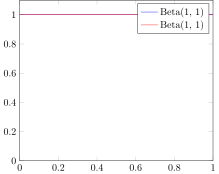

Options{:ToggleButtons,ASCIIString}([Input{ASCIIString}] Hide,"True parameters","Hide","Hide",["Hide"=>"Hide","Show"=>"Show"])

Latex("","")

In [3]:
srand(0)
arms = 2
b = Bandit(arms)
banditEstimation(b)

## Ad Hoc Exploration Strategies

In [4]:
# Select random action with probability eps, otherwise greedy
type EpsGreedy <: BanditPolicy
    eps::Real 
end
function arm(b::EpsGreedy, s::BanditStatistics)
    if rand() < b.eps
        D = DiscreteUniform(1, numArms(s))
        return rand(D)
    else
        return indmax(winProbabilities(s))
    end
end;

In [5]:
# Select arm with probability proportional to exp(precision*winprobability)
type SoftMax <: BanditPolicy
    precision::Real 
end
function arm(b::SoftMax, s::BanditStatistics)
    p = exp(b.precision * winProbabilities(s))
    p = p / sum(p)
    D = Categorical(p)
    return rand(D)
end;

In [6]:
# Select arm with highest alpha upper confidence bound
type IntervalExploration <: BanditPolicy
    alpha::Real
end
function arm(b::IntervalExploration, s::BanditStatistics)
    i = @argmax (i in 1:length(s.numWins)) quantile(Beta(s.numWins[i] + 1, s.numTries[i] - s.numWins[i] + 1), b.alpha)    
end;

Slider{Float64}([Input{Float64}] 0.5,"epsgreedy",0.5,0.0:0.1:1.0)

Slider{Int64}([Input{Int64}] 20,"softmax",20,0:2:40)

Slider{Float64}([Input{Float64}] 0.75,"interval",0.75,0.5:0.05:1.0)

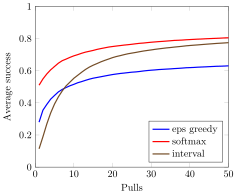

In [7]:
steps = 50
iterations = 1000
bandit = Bandit([0.1:0.2:1])
@manipulate for epsgreedy = 0:0.1:1, softmax = 0:2:40, interval = 0.5:0.05:1
    epsGreedyResults = simulateAverage(bandit, EpsGreedy(epsgreedy), steps=steps, iterations = iterations)./[1:steps]
    softMaxResults = simulateAverage(bandit, SoftMax(softmax), steps=steps, iterations = iterations)./[1:steps]
    intervalResults = simulateAverage(bandit, IntervalExploration(interval), steps=steps, iterations = iterations)./[1:steps]
    Axis([
        Plots.Linear(epsGreedyResults, legendentry="eps greedy", style="very thick", mark="none"),
        Plots.Linear(softMaxResults, legendentry="softmax", style="very thick", mark="none"),  
        Plots.Linear(intervalResults, legendentry="interval", style="very thick", mark="none")  
        ], style="legend pos=south east", ymin=0, ymax=1, xmin=0, xmax=steps, xlabel="Pulls", ylabel="Average success")
end